In [ ]:
from wmin.api import API as wminAPI
from wmin.basis import FLAV_INFO
import numpy as np
import pandas as pd # import pandas for rolling average
import matplotlib.pyplot as plt
from colibri.constants import LHAPDF_XGRID
import itertools

# Set the path to the style file
plt.style.use("../colibristyle_colorblind.mplstyle")


Using Keras backend


In [2]:
inp = {
    "flav_info": FLAV_INFO,
    "replica_range_settings": {"min_replica": 1, "max_replica": 1000},
    "impose_sumrule": True,
    "fitbasis": "EVOL",
    "nodes": [25, 20, 8],
    "activations": ["tanh", "tanh", "linear"],
    "initializer_name": "glorot_normal",
    "layer_type": "dense",
    "filter_arclength_outliers": True,
}


In [3]:
def mean_convergence_rolling_avg(samples, grid_mask, step=10, start_n=500, rolling_window_size=15):
    """
    Calculates the convergence of the running mean estimate,
    smoothing the difference plot with a rolling average.

    Args:
        samples (np.ndarray): Array of samples, shape (N_total, dim1, dim2, ...).
                              Assumes time/sample index is axis 0.
        grid_mask (list or tuple): Start and end indices for the slice on the last axis.
        step (int): Step size for calculating points to plot (reduces computation).
        start_n (int): Minimum number of samples to start calculations from.
        rolling_window_size (int): The window size for the rolling average smoothing.
                                    Must be an odd number for centered average preferred.

    Returns:
        matplotlib.figure.Figure: The figure object.
        matplotlib.axes._axes.Axes: The axes object.
    """
    if rolling_window_size % 2 == 0:
        print("Warning: rolling_window_size is even. Using center=True might shift results slightly. Consider an odd window size.")

    euclidean_distances = []
    # Calculate range values respecting start_n and step
    range_values = range(start_n, samples.shape[0] - 1, step) # Stop one early to calculate mu_N+1

    # remove photon since it is zero
    samples = samples[:, 1:, :]

    print(f"Calculating differences for N from {start_n} to {samples.shape[0]-2} with step {step}...")
    for i in range_values:
        # Slice the data ONCE efficiently
        samples_slice = samples[: i + 1, :, grid_mask[0]:grid_mask[1]]
        # Calculate means
        mu_N = np.mean(samples_slice[:-1, :, :], axis=0) # Mean up to i
        mu_N_plus_one = np.mean(samples_slice, axis=0)    # Mean up to i+1

        # Calculate the norm of the difference vector
        euclidean_distance = np.linalg.norm(mu_N - mu_N_plus_one)
        euclidean_distances.append(euclidean_distance)
    print("Calculation complete.")

    # --- Smoothing with Rolling Average ---
    # Convert to pandas Series for easy rolling calculation
    distances_series = pd.Series(euclidean_distances)
    # Calculate rolling average - center=True is usually better for smoothing trends
    # min_periods=1 ensures output even for initial points where window isn't full
    smoothed_distances = distances_series.rolling(
        window=rolling_window_size,
        center=True,
        min_periods=1 # Start smoothing immediately
    ).mean()
    # Note: center=True will produce NaNs at the very start/end if min_periods isn't set
    # or if it's larger than half the window. min_periods=1 avoids this.

    return euclidean_distances, smoothed_distances, range_values


In [4]:
def correlation_convergence_rolling_avg(samples, grid_mask, step=10, start_n=500, rolling_window_size=15):
    """
    Calculates the convergence of the running correlation estimate,
    smoothing the difference plot with a rolling average.

    Args:
        samples (np.ndarray): Array of samples, shape (N_total, dim1, dim2, ...).
                              Assumes time/sample index is axis 0.
        grid_mask (list or tuple): Start and end indices for the slice on the last axis.
        step (int): Step size for calculating points to plot (reduces computation).
        start_n (int): Minimum number of samples to start calculations from.
        rolling_window_size (int): The window size for the rolling average smoothing.
                                    Must be an odd number for centered average preferred.

    Returns:
        matplotlib.figure.Figure: The figure object.
        matplotlib.axes._axes.Axes: The axes object.
    """
    if rolling_window_size % 2 == 0:
        print("Warning: rolling_window_size is even. Using center=True might shift results slightly. Consider an odd window size.")

    frobenius_norms = []
    # Calculate range values respecting start_n and step
    range_values = range(start_n, samples.shape[0] - 1, step) # Stop one early to calculate mu_N+1

    # reshape samples
    samples = samples[:, :, grid_mask[0]:grid_mask[1]]
    # remove photon since it is zero
    samples = samples[:, 1:, :]
    samples = samples.reshape(samples.shape[0], samples.shape[1] * samples.shape[2])
    

    print(f"Calculating differences for N from {start_n} to {samples.shape[0]-2} with step {step}...")
    for i in range_values:
        # Slice the data ONCE efficiently
        samples_slice = samples[: i + 1, :]
        # Calculate Correlation matrices
        corr_N = np.corrcoef(samples_slice[:-1, :], rowvar=False) # Correlation up to i
        corr_N_plus_one = np.corrcoef(samples_slice, rowvar=False)    # Correlation up to i+1

        # Calculate the frobenius norm of the difference vector
        frob_norm = np.linalg.norm(corr_N - corr_N_plus_one, ord='fro')
        frobenius_norms.append(frob_norm)

    print("Calculation complete.")

    # --- Smoothing with Rolling Average ---
    # Convert to pandas Series for easy rolling calculation
    distances_series = pd.Series(frobenius_norms)
    # Calculate rolling average - center=True is usually better for smoothing trends
    # min_periods=1 ensures output even for initial points where window isn't full
    smoothed_distances = distances_series.rolling(
        window=rolling_window_size,
        center=True,
        min_periods=1 # Start smoothing immediately
    ).mean()
    # Note: center=True will produce NaNs at the very start/end if min_periods isn't set
    # or if it's larger than half the window. min_periods=1 avoids this.

    return frobenius_norms, smoothed_distances, range_values


def variance_convergence_rolling_avg(samples, grid_mask, step=10, start_n=500, rolling_window_size=15):
    """
    Calculates the convergence of the running variance estimate,
    smoothing the difference plot with a rolling average.

    Args:
        samples (np.ndarray): Array of samples, shape (N_total, dim1, dim2, ...).
                              Assumes time/sample index is axis 0.
        grid_mask (list or tuple): Start and end indices for the slice on the last axis.
        step (int): Step size for calculating points to plot (reduces computation).
        start_n (int): Minimum number of samples to start calculations from.
        rolling_window_size (int): The window size for the rolling average smoothing.
                                    Must be an odd number for centered average preferred.

    Returns:
        matplotlib.figure.Figure: The figure object.
        matplotlib.axes._axes.Axes: The axes object.
    """
    if rolling_window_size % 2 == 0:
        print("Warning: rolling_window_size is even. Using center=True might shift results slightly. Consider an odd window size.")

    frobenius_norms = []
    # Calculate range values respecting start_n and step
    range_values = range(start_n, samples.shape[0] - 1, step) # Stop one early to calculate mu_N+1

    # reshape samples
    samples = samples[:, :, grid_mask[0]:grid_mask[1]]
    # remove photon since it is zero
    samples = samples[:, 1:, :]
    samples = samples.reshape(samples.shape[0], samples.shape[1] * samples.shape[2])
    

    print(f"Calculating differences for N from {start_n} to {samples.shape[0]-2} with step {step}...")
    for i in range_values:
        # Slice the data ONCE efficiently
        samples_slice = samples[: i + 1, :]
        # Calculate Correlation matrices
        var_N = np.diag(np.cov(samples_slice[:-1, :], rowvar=False)) # variance up to i
        var_N_plus_one = np.diag(np.cov(samples_slice, rowvar=False))    # variance up to i+1

        # Calculate the norm of the difference vector
        frob_norm = np.linalg.norm(var_N - var_N_plus_one)
        frobenius_norms.append(frob_norm)

    print("Calculation complete.")

    # --- Smoothing with Rolling Average ---
    # Convert to pandas Series for easy rolling calculation
    distances_series = pd.Series(frobenius_norms)
    # Calculate rolling average - center=True is usually better for smoothing trends
    # min_periods=1 ensures output even for initial points where window isn't full
    smoothed_distances = distances_series.rolling(
        window=rolling_window_size,
        center=True,
        min_periods=1 # Start smoothing immediately
    ).mean()
    # Note: center=True will produce NaNs at the very start/end if min_periods isn't set
    # or if it's larger than half the window. min_periods=1 avoids this.

    return frobenius_norms, smoothed_distances, range_values


In [5]:
# Define the grid mask
grid_mask = [40, 150] # Use almost the full grid for the example
print(np.min(LHAPDF_XGRID[grid_mask[0]:grid_mask[1]]), np.max(LHAPDF_XGRID[grid_mask[0]:grid_mask[1]]))

3.29841683435992e-05 0.61723395978245


In [6]:
samples_40k = wminAPI.n3fit_pdf_grid(**{**inp, "replica_range_settings": {"min_replica": 1, "max_replica": 40000},})

/Users/markcostantini/arm64_miniconda3/envs/wmin-model-dev/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'pdf_input': 'pdf_input', 'xgrid_integration': 'xgrid_integration'}
Received: inputs={'pdf_input': 'Tensor(shape=(1, 196, 1))', 'xgrid_integration': {'xgrid_integration': 'Tensor(shape=(1, 2000, 1))'}}
  warnings.warn(msg)
/Users/markcostantini/arm64_miniconda3/envs/wmin-model-dev/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'NN_input': 'NN_input'}
Received: inputs=Tensor(shape=(1, 2000, 2))
  warnings.warn(msg)
/Users/markcostantini/arm64_miniconda3/envs/wmin-model-dev/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'NN_input': 'NN_input'}
Received: inputs=Tensor(shap

In [7]:
# Define the grid mask
grid_mask = [40, 150] # Use almost the full grid for the example

# Compute the convergence of the mean using the rolling average function
eucl_mean, smoothed_mean, range_vals_mean = mean_convergence_rolling_avg(
    samples_40k,
    grid_mask,
    step=50, # Calculate fewer points to speed up plotting
    start_n=500,
    rolling_window_size=31, # Use an odd number for centered window
)

Calculating differences for N from 500 to 35887 with step 50...
Calculation complete.


In [8]:
# Compute the correlation convergence using the rolling average function
frob_corr, smoothed_corr, range_vals_corr = correlation_convergence_rolling_avg(
    samples_40k,
    grid_mask,
    step=50, # Calculate fewer points to speed up plotting
    start_n=500,
    rolling_window_size=31, # Use an odd number for centered window
)

Calculating differences for N from 500 to 35887 with step 50...
Calculation complete.


In [10]:
# Compute the variance convergence using the rolling average function
euclid_var, smoothed_var, range_vals_var = variance_convergence_rolling_avg(
    samples_40k,
    grid_mask,
    step=50, # Calculate fewer points to speed up plotting
    start_n=500,
    rolling_window_size=31, # Use an odd number for centered window
)

Calculating differences for N from 500 to 35887 with step 50...
Calculation complete.


Plot ready.


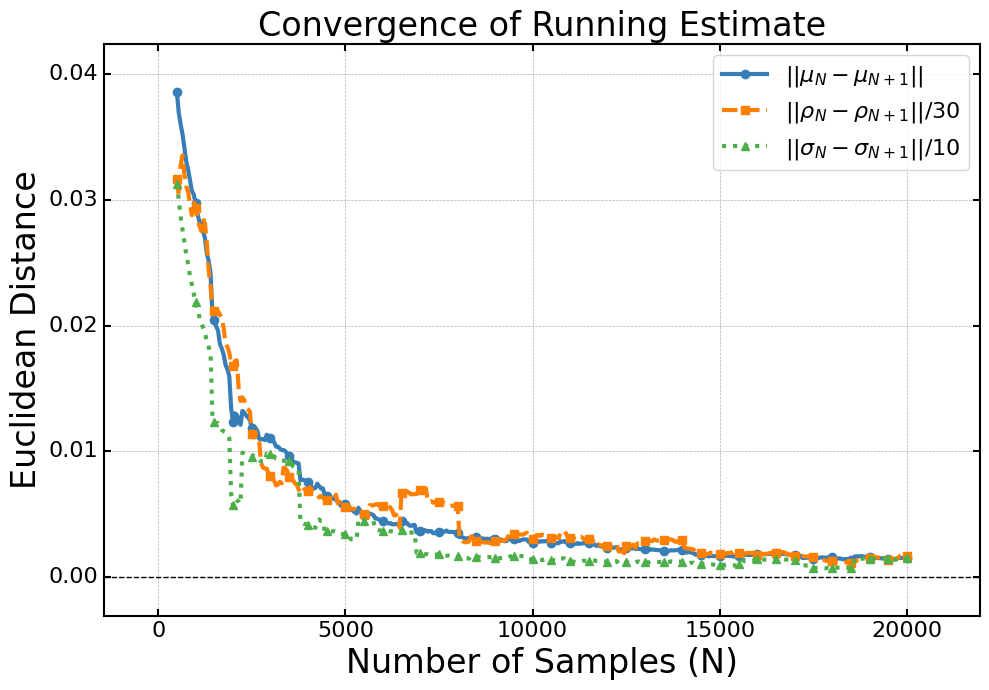

In [27]:
# plot the convergence of the mean and correlation

fig, ax = plt.subplots(figsize=(10,7))

line_styles = ['-', '--', ':']

mark_every = 10
# Plot the smoothed distances
max_idx = np.where(np.array(range_vals_mean) > 20000)[0][0]


ax.plot(
    range_vals_mean[:max_idx], 
    smoothed_mean[:max_idx], 
    linestyle='-',
    marker='o', 
    markevery=mark_every, 
    label=r"$||\mu_N - \mu_{N+1}||$", 
    linewidth=3
)

DIV_FAC = 30
ax.plot(
    range_vals_corr[:max_idx], 
    smoothed_corr[:max_idx] / DIV_FAC, 
    linestyle='--',
    marker='s',
    markevery=mark_every, 
    label=r"$||\rho_N - \rho_{N+1}||$" + f"/{DIV_FAC}", 
    linewidth=3
)

ax.plot(
    range_vals_var[:max_idx], 
    smoothed_var[:max_idx] / 10, 
    label=r"$||\sigma_N - \sigma_{N+1}||$/10", 
    linestyle=':',
    marker='^',
    markevery=mark_every, 
    linewidth=3
)

# Reference line (optional, can be adjusted based on expected noise floor)
ax.axhline(y=0.0, color="black", linestyle="--", linewidth=1)

# Style improvements
ax.set_xlabel("Number of Samples (N)", fontsize=24)
ax.set_ylabel(r"Euclidean Distance", fontsize=24)
ax.set_title("Convergence of Running Estimate", fontsize=24)

# ax.set_yscale('log')

ax.legend(fontsize=16)
ax.grid(True, which="both", linestyle='--', linewidth=0.5,) # Grid for both axes

# Improve readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
print("Plot ready.")
plt.show()


fig.savefig(f"nn_distribution_convergence.pdf", bbox_inches='tight')

